In [1]:
import time
import numpy as np
import torch

from get_args import get_args
from agent import Agent
from utils import load_filepath, load_checkpoint, plot_scores, print_debug_info, print_status, save_checkpoint

In [102]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from unityagents import UnityEnvironment

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
args = get_args()
args.framework = "DDQN"

In [5]:
for arg in vars(args):
    print("{}: {}".format(arg, getattr(args, arg)))

framework: DDQN
prioritized_replay: False
batchsize: 64
buffersize: 50000
continue: False
cpu: False
debug: False
dropout: 0.05
epsilon: 1.0
epsilon_decay: 0.999
epsilon_min: 0.075
gamma: 0.99
latest: False
learn_rate: 0.00025
momentum: 0.95
nographics: False
num_episodes: 1500
optimizer: Adam
print_count: 15
tau: 0.001
train: False
update_every: 4
verbose: False


In [6]:
start_time = time.time()
sep = "#"*50
unity_env = UnityEnvironment(file_name="Banana_Windows_x86_64/Banana.exe", no_graphics=True)
# get the default brain (In this environment there is only one agent/brain)
brain_name = unity_env.brain_names[0]
brain = unity_env.brains[brain_name]
env = unity_env.reset(train_mode=True)[brain_name]
nA = brain.vector_action_space_size
nS = len(env.vector_observations[0])

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [7]:
agent = Agent(nS, nA, device, args)

In [18]:
env = unity_env.reset(train_mode=args.train)[brain_name]
state = env.vector_observations[0]


In [19]:
for i in range(66):
    action = agent.act(state)
    env = unity_env.step(action)[brain_name]

    #collect info about new state
    reward = env.rewards[0]
    next_state = env.vector_observations[0]
    done = env.local_done[0]

    agent.teststep(state, action, reward, next_state, done)
    agent.memory.add(state, action, reward, next_state, done)

    state = next_state
    

In [20]:
batch = agent.memory.sample()
#batch = state, action, reward, next_state, done

In [22]:
print(len(batch))

5


In [29]:
print(batch[0])

tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  7.2472e-01,
         -7.5284e-01,  1.3040e+00],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  4.1817e-01,
         -5.2529e-01, -9.0982e-01],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  6.5105e-01,
          1.5874e+00, -1.2590e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ...,  8.5113e-01,
          1.3324e-03,  1.7677e-03],
        [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  7.5883e-01,
         -2.2216e+00, -2.7174e+00],
        [ 0.0000e+00,  0.0000e+00,  1.0000e+00,  ...,  1.4038e-01,
         -2.9443e-03,  2.2187e-03]], device='cuda:0')


In [28]:
for state, action, reward, next_state, done in zip(*batch):
    print("STATE:\n{}".format(state))
    print("ACTION:\n{}".format(action))
    print("REWARD:\n{}".format(reward))
    print("NEXT STATE:\n{}".format(next_state))
    print("DONE:\n{}".format(done))    

STATE:
tensor([ 0.0000,  1.0000,  0.0000,  0.0000,  0.3510,  0.0000,  0.0000,  0.0000,
         1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.7901,  1.0000,
         0.0000,  0.0000,  0.0000,  0.5089,  0.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
         0.0000,  0.0000,  0.7247, -0.7528,  1.3040], device='cuda:0')
ACTION:
tensor([2], device='cuda:0')
REWARD:
tensor([0.], device='cuda:0')
NEXT STATE:
tensor([ 1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.1774e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  5.4852e-01,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.5562e-01,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.8905e-01,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  9.1633e-01,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.8575e-01,
    

REWARD:
tensor([0.], device='cuda:0')
NEXT STATE:
tensor([1.0000, 0.0000, 0.0000, 0.0000, 0.1404, 0.0000, 0.0000, 1.0000, 0.0000,
        0.3160, 0.0000, 1.0000, 0.0000, 0.0000, 0.5504, 0.0000, 1.0000, 0.0000,
        0.0000, 0.7541, 0.0000, 0.0000, 1.0000, 0.0000, 0.1669, 0.0000, 1.0000,
        0.0000, 0.0000, 0.7808, 0.0000, 1.0000, 0.0000, 0.0000, 0.6276, 0.0000,
        0.0000], device='cuda:0')
DONE:
tensor([0.], device='cuda:0')
STATE:
tensor([ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  2.0769e-01,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  2.4205e-01,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  7.3684e-01,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,  5.6047e-01,
         0.0000e+00,  1.0000e+00,  0.0000e+00,  0.0000e+00,  8.7003e-01,
         2.4939e-04, -9.2781e+00], device=

DONE:
tensor([0.], device='cuda:0')
STATE:
tensor([ 1.0000,  0.0000,  0.0000,  0.0000,  0.2604,  1.0000,  0.0000,  0.0000,
         0.0000,  0.3069,  0.0000,  1.0000,  0.0000,  0.0000,  0.4410,  0.0000,
         0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,
         0.5207,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,
         0.0000,  0.0000,  0.8241,  0.4259, -0.0159], device='cuda:0')
ACTION:
tensor([3], device='cuda:0')
REWARD:
tensor([0.], device='cuda:0')
NEXT STATE:
tensor([0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 5.5355e-01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 5.5431e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0556e-01, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 9.1827e-01,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 3.1062e-01, 1.6679e-21,

In [11]:
print("STATE:\n{}".format(state))
print("ACTION:\n{}".format(action))
print("REWARD:\n{}".format(reward))
print("NEXT STATE:\n{}".format(next_state))
print("DONE:\n{}".format(done))

STATE:
[0.         1.         0.         0.         0.16895212 0.
 1.         0.         0.         0.20073597 1.         0.
 0.         0.         0.12865657 0.         1.         0.
 0.         0.14938059 1.         0.         0.         0.
 0.58185619 0.         1.         0.         0.         0.16089135
 0.         1.         0.         0.         0.31775284 0.
 0.        ]
ACTION:
2
REWARD:
0.0
NEXT STATE:
[0.         1.         0.         0.         0.14926681 0.
 1.         0.         0.         0.48274246 0.         0.
 0.         1.         0.         0.         1.         0.
 0.         0.16742395 1.         0.         0.         0.
 0.33388197 0.         1.         0.         0.         0.24230158
 0.         0.         1.         0.         0.63610131 0.
 0.        ]
DONE:
False


In [31]:
states, actions, rewards, next_states, dones = batch

In [32]:
t = agent.q(next_states).detach().max(1)[0].unsqueeze(1)


In [78]:
v = agent.q(next_states)
v1 = agent.qhat(next_states)

In [79]:
maxv = v.detach().max(1)[0].unsqueeze(1)

In [83]:
v

tensor([[ 6.2434e-02, -8.8969e-02,  7.9818e-02,  1.4293e-02],
        [ 1.0407e-01, -1.0316e-02,  1.2081e-01, -1.8771e-02],
        [ 7.3416e-02, -6.0011e-02,  1.1220e-01,  3.1352e-02],
        [ 6.4684e-02, -1.0135e-01,  7.0781e-02,  8.0873e-03],
        [ 8.1244e-02, -1.7985e-02,  7.0743e-02, -1.7393e-02],
        [ 5.5386e-02, -9.6316e-02,  1.4121e-01,  6.1852e-02],
        [ 8.5610e-02, -7.5163e-02,  9.4645e-02,  4.8728e-02],
        [ 6.9196e-02, -7.8773e-02,  1.5039e-01,  4.3481e-02],
        [ 3.1769e-02, -6.4573e-02,  1.5525e-01,  8.1253e-03],
        [ 4.0990e-02, -2.5473e-01,  1.0641e-01,  8.6633e-02],
        [ 6.5847e-02, -1.1458e-01,  1.8772e-01,  4.9965e-02],
        [ 5.8500e-02, -2.1212e-01,  2.0112e-01,  3.5598e-02],
        [ 8.1337e-02, -6.4989e-02,  1.6307e-01,  2.0454e-02],
        [ 1.1264e-01, -1.0067e-01,  1.4410e-01,  2.7724e-02],
        [ 6.7561e-02, -2.0058e-02,  1.4340e-01, -6.6497e-02],
        [ 6.4227e-02, -1.1934e-02,  5.8432e-02, -2.1470e-03],
        

In [93]:
argv = v.detach().argmax(1).unsqueeze(1)
argv

tensor([[2],
        [2],
        [2],
        [2],
        [0],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [0],
        [2],
        [2],
        [0],
        [2],
        [2],
        [2],
        [0],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [3],
        [3],
        [2],
        [2],
        [2],
        [2],
        [3],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [3],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [2],
        [3],
        [2],
        [2],
        [2],
        [2],
        [2],
        [0],
        [2],
        [2]], device='cuda:0')

In [95]:
v1.gather(1,argv)

tensor([[ 0.0896],
        [ 0.0834],
        [ 0.1125],
        [ 0.0923],
        [ 0.0346],
        [ 0.1332],
        [ 0.0993],
        [ 0.1779],
        [ 0.1338],
        [ 0.0989],
        [ 0.1799],
        [ 0.1818],
        [ 0.0404],
        [ 0.1958],
        [ 0.0685],
        [ 0.0557],
        [ 0.1490],
        [ 0.1631],
        [ 0.1135],
        [ 0.1510],
        [ 0.1636],
        [ 0.0839],
        [ 0.0626],
        [ 0.0470],
        [ 0.1555],
        [ 0.1434],
        [ 0.0554],
        [ 0.1209],
        [ 0.1309],
        [ 0.0839],
        [ 0.1772],
        [ 0.0374],
        [-0.0933],
        [ 0.1482],
        [ 0.1785],
        [-0.0118],
        [-0.0345],
        [ 0.0413],
        [ 0.1359],
        [ 0.1782],
        [ 0.1433],
        [ 0.1382],
        [ 0.1975],
        [ 0.1504],
        [ 0.0685],
        [ 0.0863],
        [ 0.1493],
        [ 0.1243],
        [ 0.0754],
        [ 0.1342],
        [ 0.1265],
        [ 0.1634],
        [ 0.

In [96]:
unity_env.close()

In [99]:
4**4

256

In [115]:
import math, random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

In [116]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [108]:
value = 1
decay = .999
min = .1
anneal_param = lambda x: value * decay * i

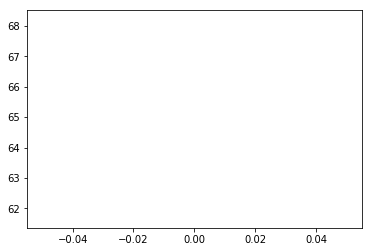

In [110]:
plt.plot(anneal_param([anneal_param(i) for i in range(10000)]))

In [111]:
beta_start = 0.4
beta_frames = 1000 
beta_by_frame = lambda frame_idx: min(1.0, beta_start + frame_idx * (1.0 - beta_start) / beta_frames)

In [118]:
plt.plot([beta_by_frame(i) for i in range(10000)])


TypeError: 'float' object is not callable

In [113]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

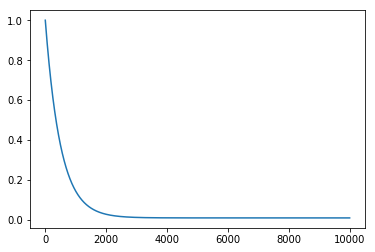

In [117]:
plt.plot([epsilon_by_frame(i) for i in range(10000)])


In [ ]:
class Node:
    def __init__(self,data)